# Transiting exoplanets

In [1]:
%pip install -e ../

Obtaining file:///home/jovyan/exoplanet_TA_testing
  Preparing metadata (setup.py) ... done
  DEPRECATION: Legacy editable install of exoplanet_lecture_utils==0.0.1 from file:///home/jovyan/exoplanet_TA_testing (setup.py develop) is deprecated. pip 25.0 will enforce this behaviour change. A possible replacement is to add a pyproject.toml or enable --use-pep517, and use setuptools >= 64. If the resulting installation is not behaving as expected, try using --config-settings editable_mode=compat. Please consult the setuptools documentation for more information. Discussion can be found at https://github.com/pypa/pip/issues/11457
  Running setup.py develop for exoplanet_lecture_utils
Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Part 1 - Statistics

In [3]:
# get data
pnasa = pd.read_csv('https://share.phys.ethz.ch/~ipa/exoplanet_lecture_FS24/nasa_exoplanet_archive_all_columns.csv')
list(pnasa)

['Unnamed: 0',
 'pl_name',
 'hostname',
 'discoverymethod',
 'pl_orbper',
 'pl_orbsmax',
 'pl_rade',
 'pl_radj',
 'pl_bmassj',
 'pl_bmasse',
 'pl_dens',
 'pl_orbeccen',
 'pl_insol',
 'pl_eqt',
 'pl_orbincl',
 'pl_tranmid',
 'pl_imppar',
 'pl_trandep',
 'pl_trandur',
 'pl_rvamp',
 'st_spectype',
 'st_teff',
 'st_rad',
 'st_mass',
 'st_met',
 'st_metratio',
 'st_logg',
 'st_age',
 'st_vsin',
 'st_radv',
 'sy_pm',
 'sy_dist',
 'sy_plx']

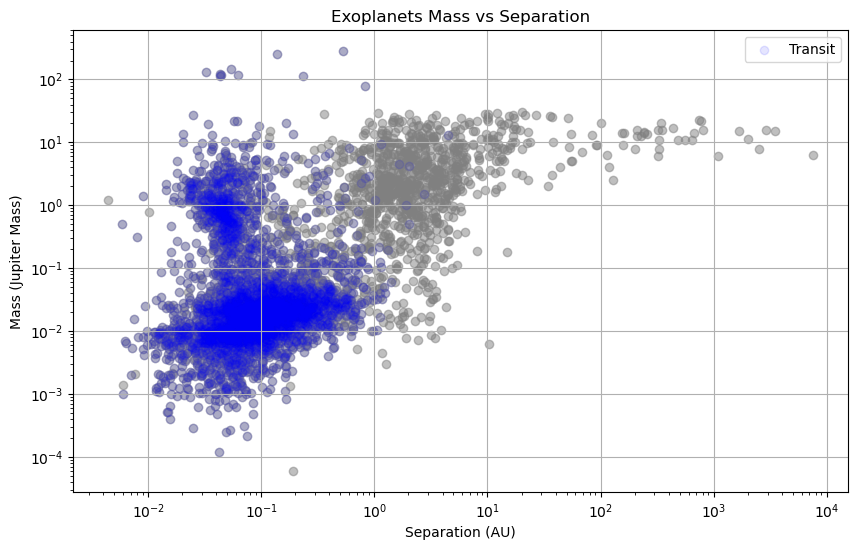

In [5]:
plt.figure(figsize=(10, 6))
plt.scatter(pnasa['pl_orbsmax'], pnasa['pl_bmassj'], alpha=0.5, color='grey')

# Highlight transiting planets
planets = pnasa.loc[pnasa["discoverymethod"]=='Transit']
plt.scatter(planets['pl_orbsmax'], planets['pl_bmassj'], alpha=0.1, color='b', label='Transit')

plt.legend()
plt.title("Exoplanets Mass vs Separation")
plt.ylabel("Mass (Jupiter Mass)")
plt.xlabel("Separation (AU)")
plt.yscale("log")
plt.xscale("log")
plt.grid(True)

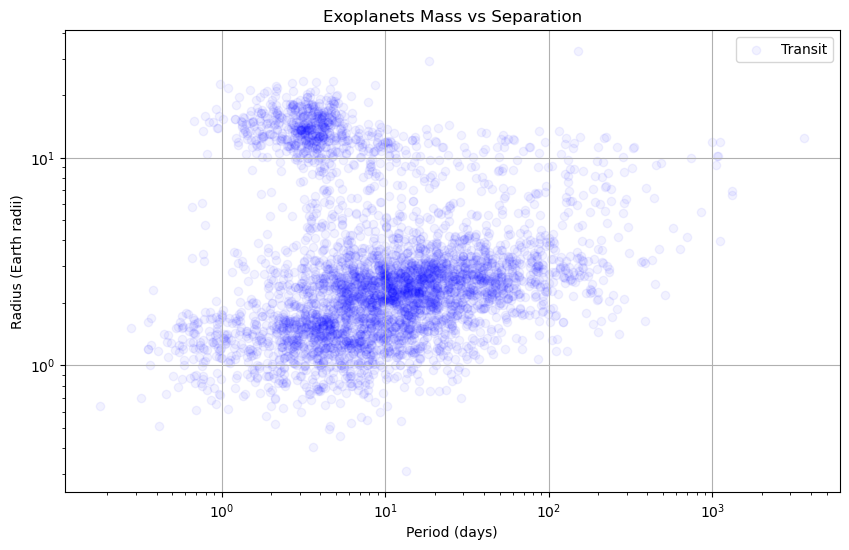

In [10]:
plt.figure(figsize=(10, 6))

# Highlight transiting planets
planets = pnasa.loc[pnasa["discoverymethod"]=='Transit']
plt.scatter(planets['pl_orbper'], planets['pl_rade'], alpha=0.05, color='b', label='Transit')

plt.legend()
plt.title("Exoplanets Mass vs Separation")
plt.ylabel("Radius (Earth radii)")
plt.xlabel("Period (days)")
plt.yscale("log")
plt.xscale("log")
plt.grid(True)


#plt.ylim(0,10)

#WASP39b = pnasa.loc[pnasa["pl_name"] == 'WASP-39 b']
#plt.scatter(WASP39b.pl_orbper,WASP39b.pl_rade,color='r')

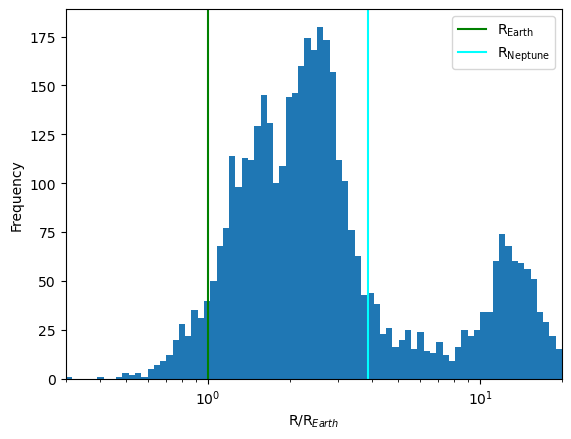

In [17]:
plt.figure()
#_ = plt.hist(planets.pl_rade, bins=80, range=(0.7, 20))

logbins = np.logspace(np.log10(0.3),np.log10(20),80)
_ = plt.hist(planets.pl_rade, bins=logbins, range=(0.7, 20))
plt.xscale("log")
plt.xlabel('R/R$_{Earth}$')
plt.ylabel('Frequency')

plot_earth = True
plot_neptune = True
plot_all = False

if plot_all: lin_mercury = plt.axvline(x=0.38,color='grey', label=r'R$_{\rm Mercury}$')
if plot_all: lin_mars    = plt.axvline(x=0.53,color='grey', label=r'R$_{\rm Mars}$')
if plot_all: lin_venus   = plt.axvline(x=0.95,color='grey', label=r'R$_{\rm Venus}$')
if plot_all or plot_earth: lin_earth   = plt.axvline(x=1.00,color='green', label=r'R$_{\rm Earth}$')
if plot_all or plot_neptune: lin_neptune = plt.axvline(x=3.88,color='cyan', label=r'R$_{\rm Neptune}$')
if plot_all: lin_uranus  = plt.axvline(x=4.00,color='grey', label=r'R$_{\rm Uranus}$')
if plot_all: lin_saturn  = plt.axvline(x=9.45,color='grey', label=r'R$_{\rm Saturn}$')
if plot_all: lin_jupiter = plt.axvline(x=11.21,color='grey', label=r'R$_{\rm Jupiter}$')

leg = plt.legend()
_ = plt.xlim([0.3,20])

In [3]:
WASP39b = pnasa.loc[pnasa["pl_name"] == 'WASP-39 b']
print(WASP39b)

     Unnamed: 0    pl_name hostname discoverymethod  pl_orbper  pl_orbsmax  \
379         379  WASP-39 b  WASP-39         Transit   4.055259      0.0486   

     pl_rade  pl_radj  pl_bmassj  pl_bmasse  ...  st_mass  st_met  \
379   14.235     1.27       0.28     88.989  ...     0.93    0.01   

     st_metratio  st_logg  st_age  st_vsin  st_radv      sy_pm  sy_dist  \
379       [Fe/H]     4.45     9.0      1.4   -58.48  19.055928  213.982   

      sy_plx  
379  4.64482  

[1 rows x 33 columns]


## Part 2 - Transit fitting

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import astropy.constants as const
from astropy.modeling.models import Linear1D
from astropy.modeling.fitting import LevMarLSQFitter, LinearLSQFitter
from scipy.optimize import minimize
import h5py
import batman

In [9]:
# example batman model
params = batman.TransitParams()       #object to store transit parameters
params.t0 = 0.                        #time of inferior conjunction
params.per = 1.51087081                      #orbital period
params.rp = 0.09689*const.R_jup/(0.117*const.R_sun)                   #planet radius (in units of stellar radii)
params.a = 0.01111*u.AU/(0.117*const.R_sun)                       #semi-major axis (in units of stellar radii)
params.inc = 87.                      #orbital inclination (in degrees)
params.ecc = 0.                       #eccentricity
params.w = 90.                        #longitude of periastron (in degrees)
params.limb_dark = "quadratic"        #limb darkening model
params.u = [0.1, 0.]      #limb darkening coefficients [u1, u2, u3, u4]

t = np.linspace(-0.01, 0.01, 1000)  #times at which to calculate light curve
m = batman.TransitModel(params, t)    #initializes model

Text(0.5, 0, 'time [days]')

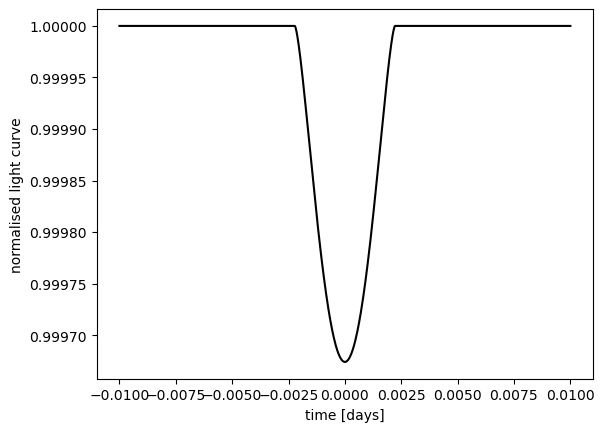

In [10]:
light_curve = m.light_curve(params) 
plt.figure()
plt.plot(t, light_curve, "black")
plt.ylabel("normalised light curve")
plt.xlabel("time [days]")

Text(0.5, 0, 'time [days]')

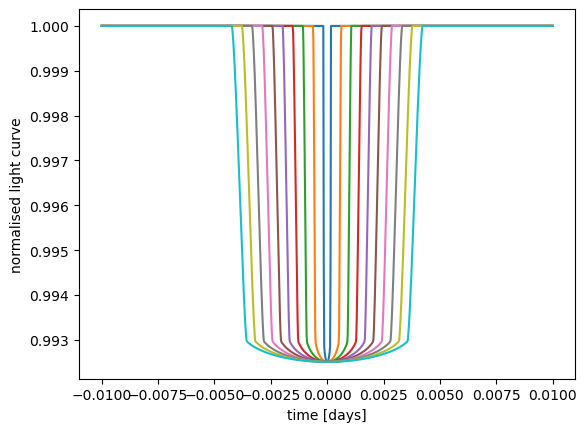

In [11]:
# plot
plt.figure()

params.inc = 90
# update parameter eg. period
for period in np.linspace(0.02,0.5,10):
    params.per = period

    # recalculate the ligth curve fit from batman
    light_curve = m.light_curve(params) 
    plt.plot(t, light_curve)

plt.ylabel("normalised light curve")
plt.xlabel("time [days]")

Text(0.5, 0, 'time [days]')

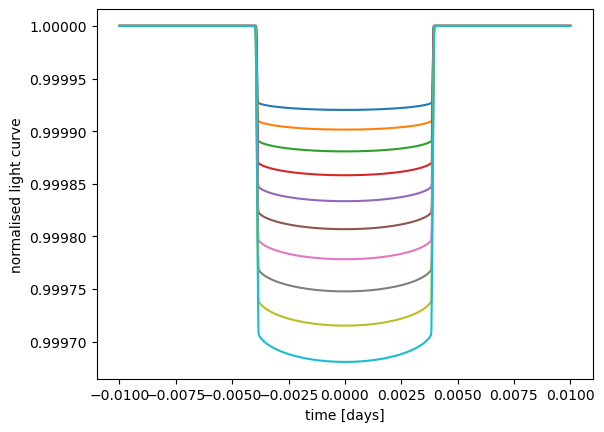

In [12]:
# plot
plt.figure()

params.per = 0.5
params.inc = 90

# update parameter eg. period
for val in np.linspace(0.01,0.02,10):
    params.rp = val*const.R_jup/(0.117*const.R_sun)

    # recalculate the ligth curve fit from batman
    light_curve = m.light_curve(params) 
    plt.plot(t, light_curve)

plt.ylabel("normalised light curve")
plt.xlabel("time [days]")

Text(0.5, 0, 'time [days]')

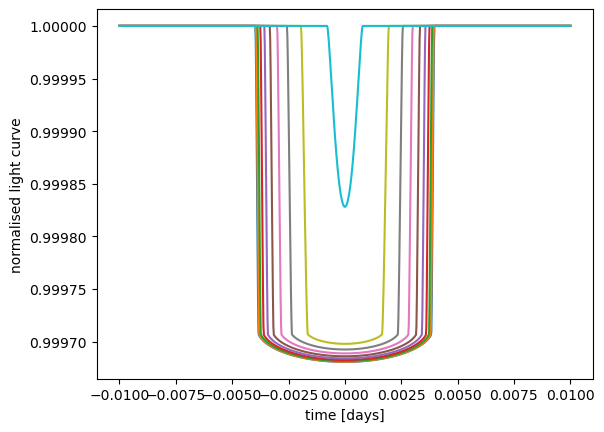

In [13]:
# plot
plt.figure()

params.per = 0.5
params.inc = 90

# update parameter eg. period
for incl in np.linspace(90,87.2,10):
    params.inc = incl

    # recalculate the ligth curve fit from batman
    light_curve = m.light_curve(params) 
    plt.plot(t, light_curve)

plt.ylabel("normalised light curve")
plt.xlabel("time [days]")

### 2.2 WASP-39 b

In [2]:
! wget https://share.phys.ethz.ch/~ipa/exoplanet_lecture_FS24/firefly_normalized_specphot.h5

# Only need to run this once - it will fetch the data and copy it to the directory here

--2025-03-18 15:39:11--  https://share.phys.ethz.ch/~ipa/exoplanet_lecture_FS24/firefly_normalized_specphot.h5
Resolving share.phys.ethz.ch (share.phys.ethz.ch)... 129.132.80.27, 2001:67c:10ec:3dc4::39
Connecting to share.phys.ethz.ch (share.phys.ethz.ch)|129.132.80.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88066048 (84M)
Saving to: ‘firefly_normalized_specphot.h5’

firefly_normalized_ 100%[===================>]  83.99M   245MB/s    in 0.3s    

2025-03-18 15:39:11 (245 MB/s) - ‘firefly_normalized_specphot.h5’ saved [88066048/88066048]



In [5]:
# load data
filename = "firefly_normalized_specphot.h5"
with h5py.File(filename, "r") as file:
    print(file.keys())
    data = file["specphot"][()]


<KeysViewHDF5 ['specphot']>


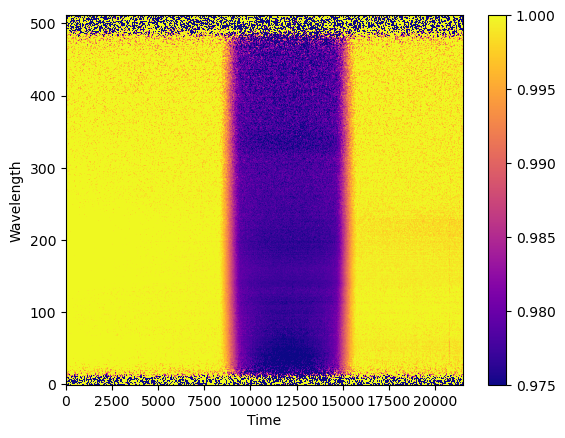

In [3]:
# Visualise the data
plt.figure()
plt.imshow(data, aspect="auto", origin="lower", vmax=1., vmin=0.975, cmap="plasma")
plt.xlabel('Time')
plt.ylabel('Wavelength')
plt.colorbar()

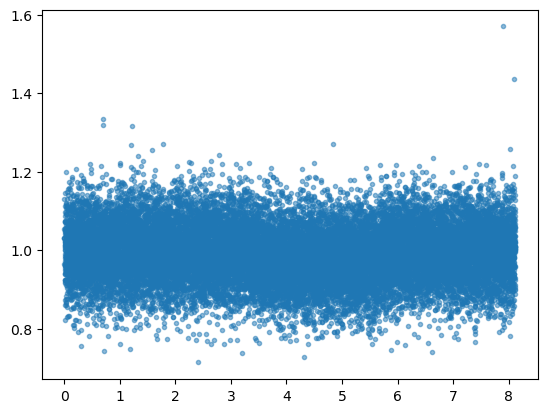

In [6]:
plt.figure()
time = np.arange(data.shape[1])*1.36/3600
signal_white_light = data[:, :].mean(axis=0)
plt.plot(time, signal_white_light, ".", alpha=0.5) # white light curve 

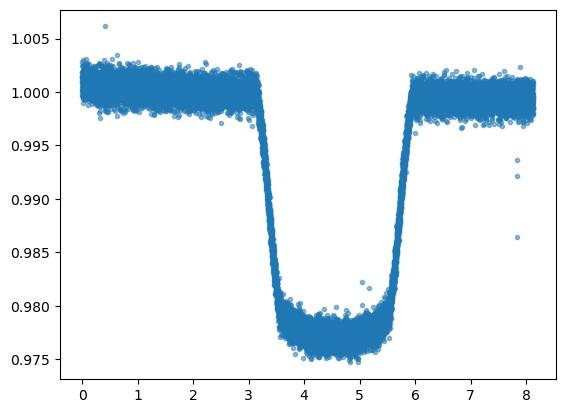

In [7]:
plt.figure()
time = np.arange(data.shape[1])*1.36/3600
signal_white_light = data[20:480, :].mean(axis=0)
plt.plot(time, signal_white_light, ".", alpha=0.5) # white light curve 

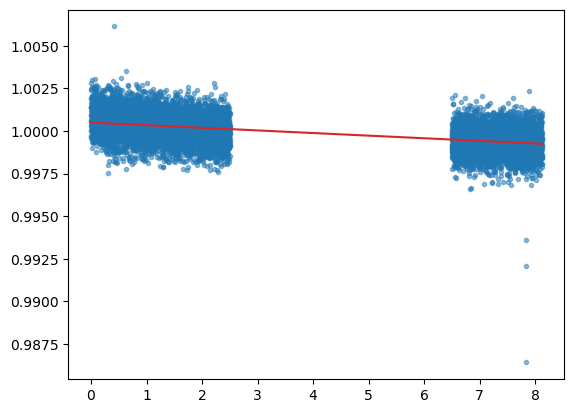

In [8]:
# fit straight line to the data out of transit
ind = np.where((time<2.5) | (time>6.5))

x = time[ind]
y = signal_white_light[ind]

# initialize a linear fitter
fit = LinearLSQFitter()

# initialize a linear model
line_init = Linear1D()

# fit the data with the fitter
fitted_line = fit(line_init, x, y)

# Plot
plt.figure()
_, = plt.plot(x, y, ".", alpha=0.5)
_, = plt.plot(x, fitted_line(x), color="C3")

0.022728506165149875
379    1.320203
Name: st_rad, dtype: float64
379    1.27
Name: pl_radj, dtype: float64


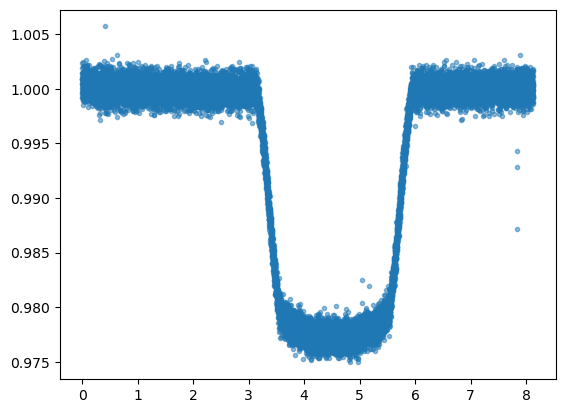

In [9]:
# correct the data and estimate the average transit depth (and thus radius)
plt.figure()
signal_white_light_corrected = signal_white_light/fitted_line(time)
plt.plot(time, signal_white_light_corrected, ".", alpha=0.5) # white light curve 

centre_ind = np.where((time>4.25) & (time<4.75))
centre_trans_depth = 1 - signal_white_light_corrected[centre_ind].mean()
print(centre_trans_depth)

Rstar = WASP39b.st_rad
R_sol_to_jup = 9.73
radius_est = np.sqrt(centre_trans_depth)*Rstar * R_sol_to_jup
print(radius_est)
print(WASP39b.pl_radj)

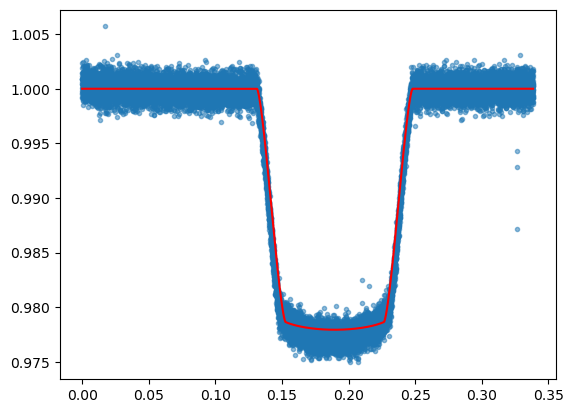

In [10]:
# Back to BATMAN

# initial guess - WASP-39b
params = batman.TransitParams()       #object to store transit parameters
params.t0 = 4.55/24                        #time of inferior conjunction
params.per = 4.055259                     #orbital period
params.rp = 1.32*const.R_jup/(0.92*const.R_sun)                   #planet radius (in units of stellar radii)
params.a = 0.0486*u.AU/(0.95*const.R_sun)                       #semi-major axis (in units of stellar radii)
params.inc = 87.                      #orbital inclination (in degrees)
params.ecc = 0.                       #eccentricity
params.w = 90.                        #longitude of periastron (in degrees)
params.limb_dark = "linear"        #limb darkening model
params.u = [0.1]      #limb darkening coefficients [u1, u2, u3, u4]

#t = np.linspace(0, 8.3, 1000)/24  #times at which to calculate light curve
m = batman.TransitModel(params, time/24)    #initializes model
lc = m.light_curve(params) 

plt.figure()
plt.plot(time/24, signal_white_light_corrected, ".", alpha=0.5)
plt.plot(time/24, lc, color='red')

In [11]:
# quick minimisation function to fit BATMAN to the lightcurve

def transit_model(p, t, lc, params):
    t0, per, rp, incl, u1 = p
    # model
    params.t0 = t0                        #time of inferior conjunction
    params.rp = rp               #planet radius (in units of stellar radii)
    params.per = per
    params.a = 0.0486*u.AU/(0.95*const.R_sun)                       #semi-major axis (in units of stellar radii)
    params.inc = incl                      #orbital inclination (in degrees)
    params.ecc = 0.                       #eccentricity
    params.w = 90.                        #longitude of periastron (in degrees)
    params.limb_dark = "linear"        #limb darkening model
    params.u = [u1]      #limb darkening coefficients [u1, u2, u3, u4]
    
    return np.sum((m.light_curve(params) - lc)**2)

opt = minimize(transit_model, 
               x0=[4.55/24, 4.055259, 1.32*const.R_jup/(0.92*const.R_sun), 87, 0.1],
               args =(time/24, signal_white_light_corrected, params))

print(opt)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.013027635387977028
        x: [ 1.892e-01  3.863e+00  1.471e-01  8.764e+01  2.325e-01]
      nit: 20
      jac: [-3.397e-07 -1.087e-07 -7.334e-08 -3.423e-08  6.938e-08]
 hess_inv: [[ 1.699e-04 -2.003e-03 ...  5.199e-03  1.568e-04]
            [-2.003e-03  4.539e+01 ... -1.141e+02 -8.699e+00]
            ...
            [ 5.199e-03 -1.141e+02 ...  3.013e+02  3.162e+01]
            [ 1.568e-04 -8.699e+00 ...  3.162e+01  1.404e+01]]
     nfev: 150
     njev: 25


379    1.287772
Name: st_rad, dtype: float64


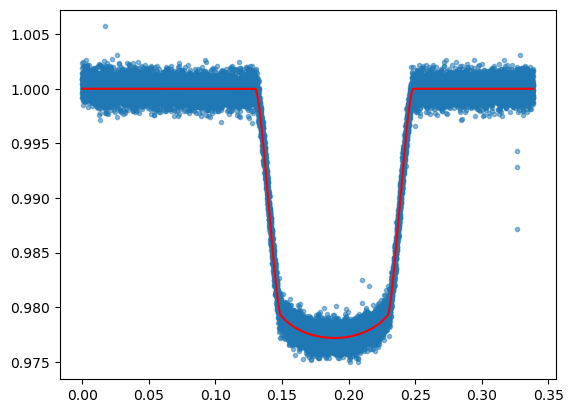

In [12]:
# optimised model
params.t0 = opt.x[0]                       #time of inferior conjunction
params.per = opt.x[1]                      #orbital period
params.rp = opt.x[2]
params.inc = opt.x[3]
params.u = [opt.x[4]]

lc = m.light_curve(params)

plt.figure()
plt.plot(time/24, signal_white_light_corrected, ".", alpha=0.5)
plt.plot(time/24, lc, color='red')

opt_rad = opt.x[2]*Rstar * R_sol_to_jup

print(opt_rad)


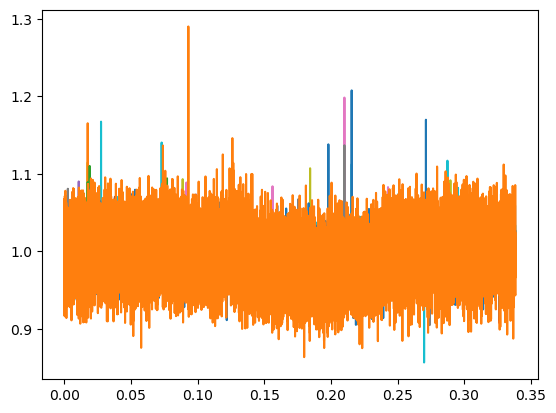

In [13]:
# bin the wavelengths and fit separately
data_exclude = data[20:480, :]

bin_wid = 5
signal_wav_binned = [data_exclude[ni*bin_wid:(ni+1)*bin_wid].mean(axis=0) for ni in range(int(len(data_exclude)/bin_wid))]/fitted_line(time)

plt.figure()
for signal_wav in signal_wav_binned:
    plt.plot(time/24,signal_wav)


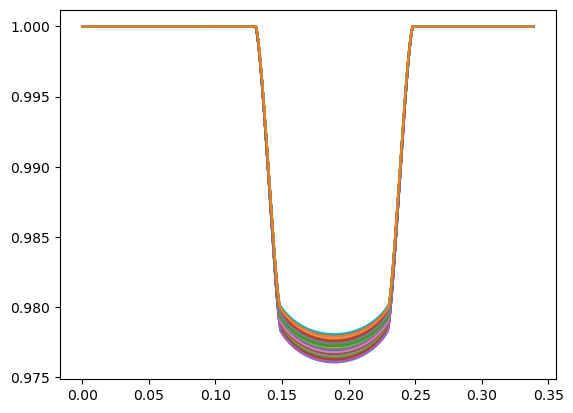

In [14]:
# now only fit for transit radius
def transit_rad_fit(rp, t, lc, params):
    # model
    params.rp = rp    
    return np.sum((m.light_curve(params) - lc)**2)

save_radii = []
plt.figure()
for signal_wav in signal_wav_binned:
    
    # optimise BATMAN for each wavelength bin (/channel bin really) separately
    opt = minimize(transit_rad_fit, 
               x0=1.287772*const.R_jup/(0.92*const.R_sun),
               args =(time/24, signal_wav, params))
    
    # optimised model
    save_radii.append(opt.x)
    params.rp = opt.x
    lc = m.light_curve(params)

    # plot
    plt.plot(time/24, lc)

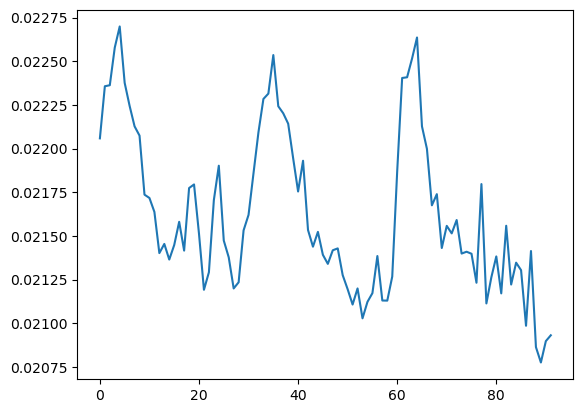

In [16]:
plt.figure()
plt.plot(range(len(save_radii)),[rad**2 for rad in save_radii]) # x axis is not actually wavelength yet - just binned channels of the detector